In [6]:
%%writefile ../../src/ecg/ecg_filters.py
import numpy as np
from scipy.signal import butter, sosfiltfilt


def bandpass_filter(signal, fs, filter_order=6, low_cut=0.5, high_cut=40):
    """
    Apply a bandpass filter to an ECG signal.

    Parameters:
    - signal (numpy array): The ECG signal.
    - fs (float): Sampling frequency of the ECG signal.
    - filter_order (int): Order of the filter.
    - low_cut (float): Low cutoff frequency for the high-pass filter.
    - high_cut (float): High cutoff frequency for the low-pass filter.

    Returns:
    - numpy array: Filtered ECG signal.
    """
    
    if fs <= high_cut * 2:
        raise ValueError("Sampling frequency is too low for the selected high cutoff frequency.")

    nyquist_freq = 0.5 * fs
    low = low_cut / nyquist_freq
    high = high_cut / nyquist_freq
    
    # Apply the bandpass filter
    sos = butter(filter_order, [low, high], btype='band', output='sos', analog=False)
    
    if len(np.shape(signal)) == 2:
        # Multi-channel ECG signal
        [num_samples, num_channels] = np.shape(signal)
        fsig = np.zeros([num_samples, num_channels])
        for i in range(num_channels):
            fsig[:,i] = sosfiltfilt(sos, signal[:,i])
    elif len(np.shape(signal)) == 1:
        # Single-channel ECG signal
        fsig = sosfiltfilt(sos, signal)
        
    return fsig

Overwriting ../../src/ecg/ecg_filters.py


In [31]:
import os

import matplotlib.pyplot as plt

import scipy.io as sio

from src.data.load_data import load_ecg_mat_file
from src.config import TRAINING_DIR
from src.ecg.ecg_filters import bandpass_filter

In [32]:
sample_mat_file = [os.path.join(content[0], filename) for content in os.walk(TRAINING_DIR) for filename in content[2] if filename.endswith('.mat')][0]
sample_mat_file

'/Users/ajaykarthicksenthilkumar/dev/personal/ECGHeartRhythmAnalysis/data/physionet.org/files/challenge-2017/1.0.0/training/A05/A05087.mat'

In [35]:
ecg_signal = sio.loadmat(sample_mat_file)['val'][0]

In [36]:
def plot_ecg(signal, title='ECG signal'):
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.show()

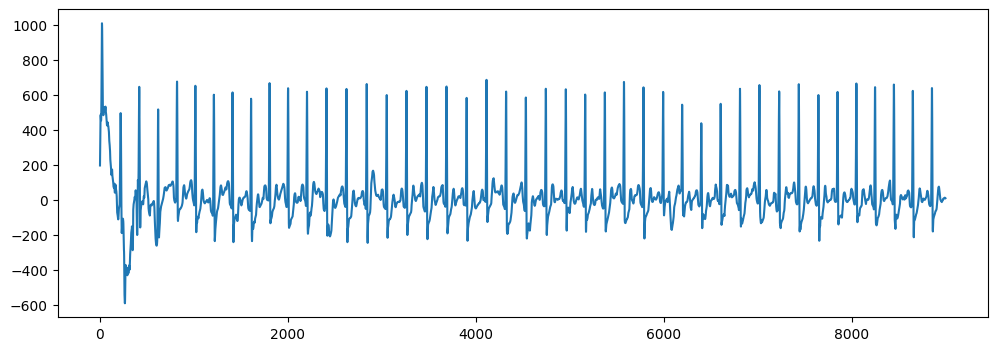

In [37]:
plot_ecg(ecg_signal)

In [39]:
# find fs
def print_hea_file(hea_file):
    with open(hea_file, 'r') as f:
        print(f.read())

header_file = sample_mat_file.replace('.mat', '.hea')
print_hea_file(header_file)

A05087 1 300 9000 07:04:43 1/04/2000 
A05087.mat 16+24 1000/mV 16 0 196 0 0 ECG 



In [46]:
fs = 300
bandpass_filtered_ecg = bandpass_filter(ecg_signal, fs=fs, filter_order=6, low_cut=0.5, high_cut=40)

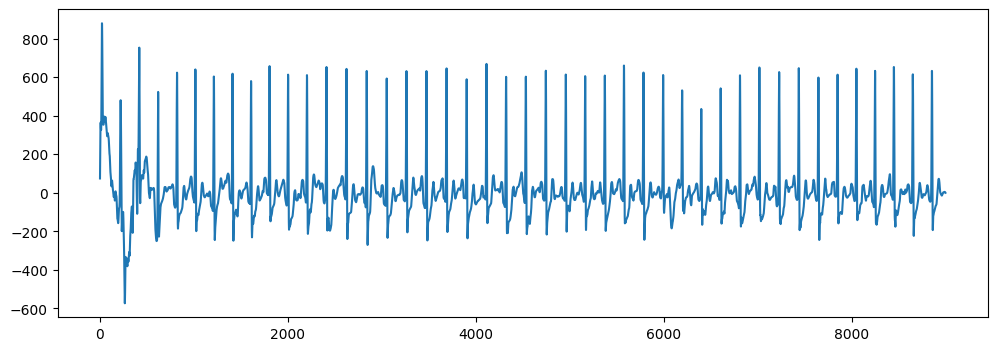

In [47]:
plot_ecg(bandpass_filtered_ecg)

In [48]:
import numpy as np


def normalize(signal):
    """
    Normalize an ECG signal.

    Parameters:
    - signal (numpy array): The ECG signal.

    Returns:
    - numpy array: Normalized ECG signal.
    """
    return (signal - np.mean(signal)) / np.std(signal)

def min_max_normalize(signal):
    """
    Normalize an ECG signal using the min-max method.

    Parameters:
    - signal (numpy array): The ECG signal.

    Returns:
    - numpy array: Normalized ECG signal.
    """
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))


def symmetric_min_max_normalize(signal):
    """
    Normalize an ECG signal using the symmetric min-max method.

    Parameters:
    - signal (numpy array): The ECG signal.

    Returns:
    - numpy array: Normalized ECG signal.
    """
    return 2 * (signal - np.min(signal)) / (np.max(signal) - np.min(signal)) - 1



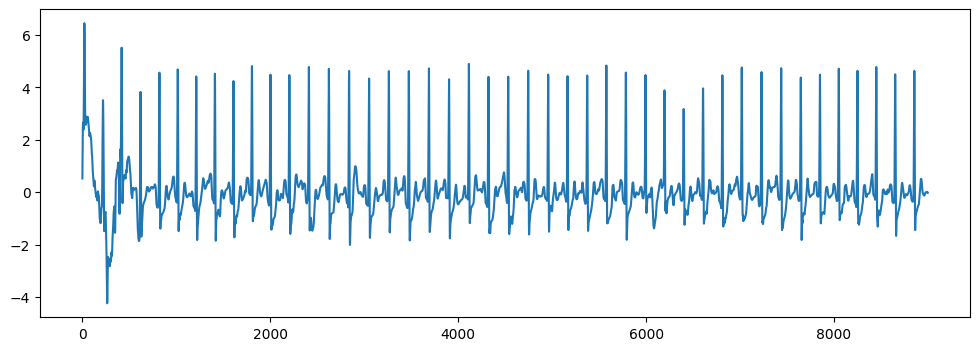

In [49]:
plot_ecg(normalize(bandpass_filtered_ecg))

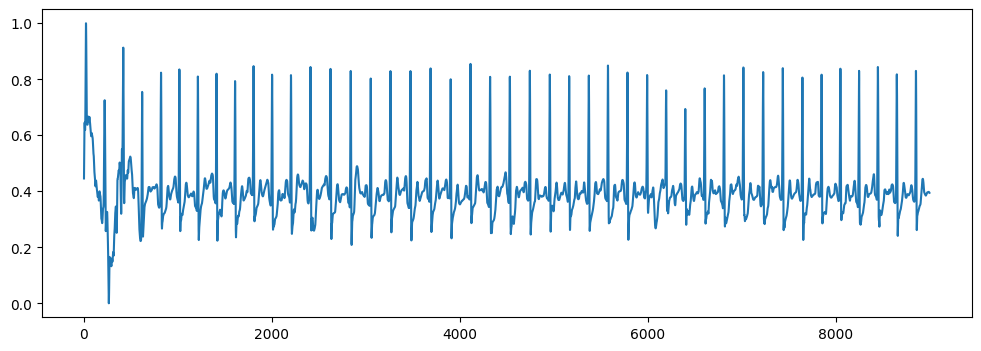

In [50]:
plot_ecg(min_max_normalize(bandpass_filtered_ecg))

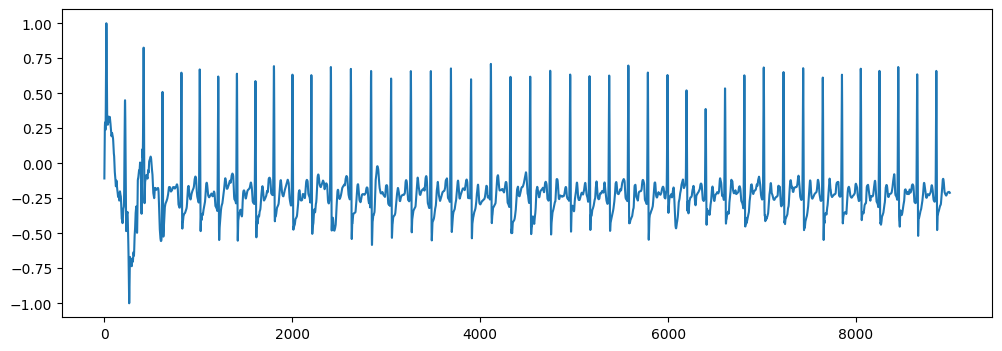

In [51]:
plot_ecg(symmetric_min_max_normalize(bandpass_filtered_ecg))

1. Min-Max Scaling (Normalization to a Range, e.g., -1 to 1):

- This method scales the ECG data so that its amplitude lies within a specified range, typically -1 to 1.
- It preserves the proportional differences in amplitude within each signal.
- Useful if the relative amplitude within a signal is important.

2. Standardization (Z-score Normalization):

- This method transforms the data to have a mean of 0 and a standard deviation of 1.
- It is less affected by outliers compared to min-max scaling.
- Standardization can be more suitable if the machine learning models assume that the input features are normally distributed.
- Useful if we want to compare features across different subjects or signals.

Standardization might be more appropriate if the classification relies heavily on the statistical properties of the signal, like mean and variance, and we need to compare these properties across different subjects or recordings.

Min-Max Scaling could be more suitable if the relative amplitude within each ECG recording is crucial for identifying specific features related to arrhythmias.

In [62]:
import neurokit2 as nk

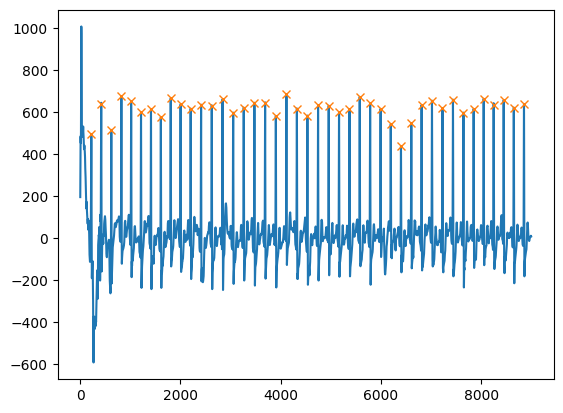

In [75]:
ecg_cleaned = nk.ecg_clean(ecg_signal, sampling_rate=fs)
_, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)

plt.plot(ecg_signal) 
plt.plot(rpeaks["ECG_R_Peaks"], ecg_signal[rpeaks["ECG_R_Peaks"]], "x")
plt.show()

In [87]:
## Locate other waves peaks
_, waves_peak = nk.ecg_delineate(ecg_cleaned, rpeaks, sampling_rate=fs, method="peak")

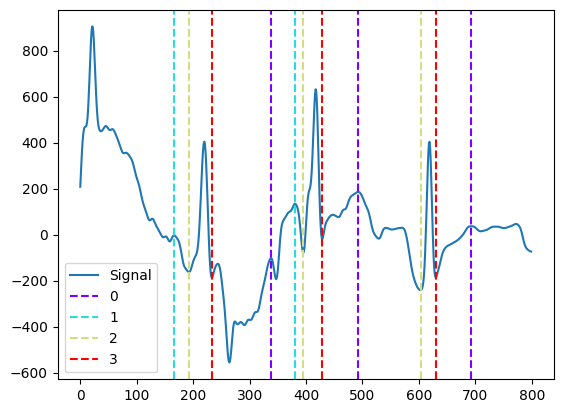

In [97]:
plot = nk.events_plot([waves_peak['ECG_T_Peaks'][:3], 
                       waves_peak['ECG_P_Peaks'][:3],
                       waves_peak['ECG_Q_Peaks'][:3],
                       waves_peak['ECG_S_Peaks'][:3]], ecg_cleaned[:800])

In [105]:
peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs, method="pantompkins1985")

,HRV_MeanNN,HRV_SDNN,HRV_SDANN1,HRV_SDNNI1,HRV_SDANN2,HRV_SDNNI2,HRV_SDANN5,HRV_SDNNI5,HRV_RMSSD,HRV_SDSD,...,HRV_IQRNN,HRV_SDRMSSD,HRV_Prc20NN,HRV_Prc80NN,HRV_pNN50,HRV_pNN20,HRV_MinNN,HRV_MaxNN,HRV_HTI,HRV_TINN
0,678.682171,75.617876,NaN,NaN,NaN,NaN,NaN,NaN,101.898642,102.61194,...,66.666667,0.742089,639.333333,727.333333,55.813953,74.418605,323.333333,786.666667,8.6,390.625


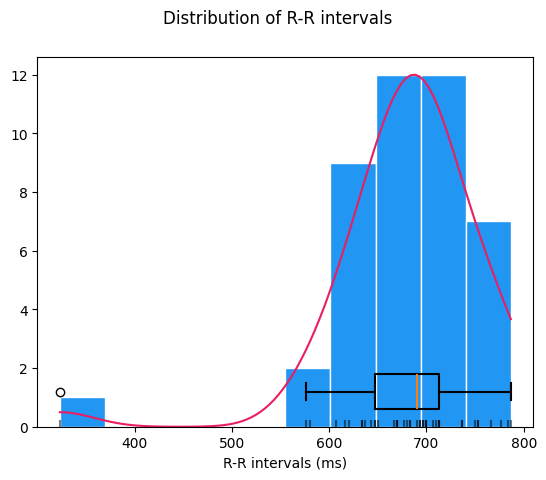

In [108]:
hrv_time = nk.hrv_time(peaks, sampling_rate=fs, show=True)
hrv_time

/Users/ajaykarthicksenthilkumar/miniconda/envs/ecg_proj_env/lib/python3.9/site-packages/neurokit2/hrv/hrv_nonlinear.py:474: NeuroKitWarning: DFA_alpha2 related indices will not be calculated. The maximum duration of the windows provided for the long-term correlation is smaller than the minimum duration of windows. Refer to the `scale` argument in `nk.fractal_dfa()` for more information.
  warn(


,HRV_SD1,HRV_SD2,HRV_SD1SD2,HRV_S,HRV_CSI,HRV_CVI,HRV_CSI_Modified,HRV_PIP,HRV_IALS,HRV_PSS,...,HRV_SampEn,HRV_ShanEn,HRV_FuzzyEn,HRV_MSEn,HRV_CMSEn,HRV_RCMSEn,HRV_CD,HRV_HFD,HRV_KFD,HRV_LZC
0,72.557599,56.197329,1.291122,12809.979828,0.77452,4.814519,174.103875,0.790698,0.815789,0.967742,...,3.044522,4.768947,1.426186,1.20907,1.247608,1.310437,2.100265,2.022589,2.064518,1.388114


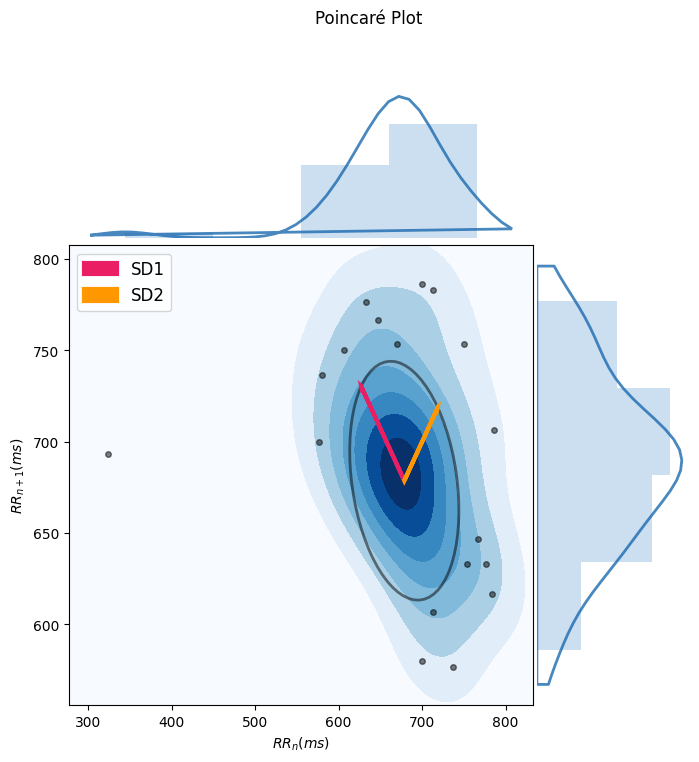

In [109]:
hrv_nonlinear = nk.hrv_nonlinear(peaks, sampling_rate=fs, show=True)
hrv_nonlinear